<a href="https://colab.research.google.com/github/MYOUSSF/PINNs/blob/main/Determination_of_moment_inertia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification of moment of inertia in satellites using orientations

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import scipy
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

# The Euler equation for satellite motion
$$
\mathbb{I} \dot{ \boldsymbol{\Omega}} = -  \boldsymbol{\Omega} \times \mathbb{I} \boldsymbol{\Omega}+ \mathbf{T} \, .
$$
Here, $\mathbb{I}$ is the moment of inertia (unknown) and $\boldsymbol{\Omega}$ is the angular velocity in the body frame.  The vector $\mathbf{T}$ is the torque applied in the body frame. It is assumed that $\boldsymbol{\Omega}(t_i) = \boldsymbol{\Omega}_i$ can be measured experimentally at several times $t_1, \ldots, t_n$. We will use these values of $\boldsymbol{\Omega}_i $ to try to determine $\mathbb{I}$ using PINNs.

Fiirst, we initialize true system and produce the data points $\boldsymbol{\Omega}_i$ from the true solution.

We use $\mathbb{I} = {\rm diag}(1, 2,3)$ to produce the data with given initial condition.


In [ ]:
tmax = 10
nt = 100
t_eval = np.linspace(0,tmax, nt)
Omega0 = np.array([1, 1, -1])
I_true = np.diag([1,2,3])
I_true_inv = np.linalg.inv(I_true)

In [ ]:
def Torque(t, y, numerical):

    if numerical == 0:
        val = np.array([np.cos(t), np.sin(t),  np.cos(t)])
    else:
        T = [tf.cos(t), tf.sin(t), tf.cos(t)]
        val = tf.squeeze(T)
    return val


def Euler_top(t, y, numerical):
    nonlinear_term = np.cross(y, np.matmul(I_true, y))
    dydt =  np.matmul(I_true_inv, - nonlinear_term + Torque(t, y, numerical))
    return dydt


sol = solve_ivp(Euler_top, [0, tmax], Omega0, t_eval=t_eval, args=[0])


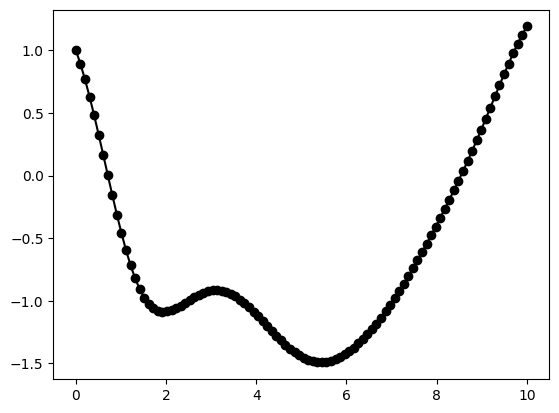

In [ ]:

plt.figure(1)
plt.clf()
t_sol = sol.t
Omega_sol = sol.y
plt.plot(t_sol, Omega_sol[1, :], 'ko-')


Next, we define the residue function for Euler's top with external torque

In [ ]:
def Euler_eq_res(Omega, Omega_t, t, params):
    #print('params =', params)
    params = tf.squeeze(params)
    a = params[0:3]
    b = params[3:6]
    #Moment of inertia
    I =  [[a[0], b[0], b[1]],
          [b[0], a[1], b[2]],
          [b[1], b[2], a[2]]]
    muT = tf.transpose(tf.matmul(I, Omega), [1, 0])
    OmegaT = tf.transpose(Omega, [1, 0])
    mu_t = tf.matmul(I, Omega_t)
    nonlinear_term = tf.transpose(tf.linalg.cross(OmegaT, muT), [1, 0])

    res = mu_t + nonlinear_term - Torque(t, Omega, 1)
    return res


Time derivatives:

In [ ]:
def get_derivatives(model, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        Omega = model(t)
        Omega_t = []
        for j in range(3):
            Omega_j = Omega[:, j:j+1]
            Omega_t_j = tape.gradient(Omega_j, t)
            Omega_t.append(Omega_t_j)
    Omega_t = tf.squeeze(tf.stack(Omega_t))
    Omega = tf.transpose(Omega, [1, 0])
    del tape

    return Omega, Omega_t


Defining the model and parameters. The parameter vector is $\mathbf{p}=(\mathbf{a}, \mathbf{b})$, where vectors $\mathbf{a}$ and $\mathbf{b}$ define the symmetric matrix of moments of inertia
$$
\mathbb{I} = \left(
  \begin{array}{ccc}
  a_1 & b_1 & b_2 \\
  b_1 & a_2 & b_3 \\
  b_2 & b_3 & a_3
  \end{array}
  \right)
$$
The true values are $\mathbf{a}_* = (1,2,3)$ and $\mathbf{b}_* = (0,0,0)$. The initial conditions are $\mathbf{a} = (2, 3, 4)$ and $\mathbf{b}=(-1,1,1)$.

In [ ]:
# Starting guess for the parameters; remember that the real value is c_star = 3
params = tf.Variable([2, 3, 4, -1, 1, 1])

class Inertia_model(keras.Model):
    def __init__(self,
            output_dim=3,
            num_layers=4,
            size_layer=64,
            activation="tanh",
            kernel_initializer='glorot_normal',
            params = params,
            **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.params = params
        # Define NN architecture
        self.hidden = [Dense(size_layer,
                             activation=activation,
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_layers)]
        self.out = Dense(output_dim)
        a = tf.random.uniform((1, 3), 1, 5)
        b = tf.random.uniform((1, 3), -1, 1)
        self.params = tf.concat([a, b], -1)

    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.num_layers):
            X = self.hidden[i](X)
        return self.out(X)



Initializing and building the model

In [ ]:
model = Inertia_model(
    num_layers=5,
    size_layer=64
    )

model.build(input_shape=(None,1))


The loss of the model with its gradient:

In [ ]:
def loss_fn(model, t_int):
    params = model.params

    Omega, Omega_t = get_derivatives(model, t_int)

    res = Euler_eq_res(Omega, Omega_t, t_int, params)

    loss_res = tf.reduce_mean(res**2)

    #print('shape of t=',tf.shape(t1))
    #print('shape of m(t)=', tf.shape(model(t1)))
    #print('shape of Omega=', tf.shape(Omega1))

    # This loss computes the difference between predicted u from the model and true values
    loss_params = tf.reduce_mean((model(t1) - Omega1)**2)

    return loss_res + loss_params


def loss_grad(model, t_int):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, t_int)
    # These are gradients with respect to the weights and parameters
    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, grad_theta


@tf.function
def train_step(model, t_int):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_grad(model, t_int)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

A function that generates a batch for data points during the training. We need interior points and other points for the initial condition.

In [ ]:
def batch_generator(int_batch_size=100):
    t_int = tf.random.uniform((int_batch_size, 1), 0, tmax)
    return t_int


A class that defines the model we'll use throughout the notebook.

In [ ]:
# Number of training epochs
N = 10000
# learning rate
learning_rate = 1e-4
t1 = tf.transpose(tf.Variable([t_sol], dtype=tf.float32), [1, 0])
Omega1 = tf.transpose(tf.Variable(Omega_sol, dtype=tf.float32), [1, 0])

optim = keras.optimizers.Adam(learning_rate=learning_rate)
hist = []
t_int = batch_generator(100)
for i in range(N):
    loss = train_step(model, t_int)
    hist.append(loss.numpy())

    if i%1000 == 0:
      print('Epoch',i,"loss:", loss.numpy())


Epoch 0 loss: 1.3443196
Epoch 1000 loss: 0.13194343
Epoch 2000 loss: 0.12784582
Epoch 3000 loss: 0.1262881
Epoch 4000 loss: 0.12593645
Epoch 5000 loss: 0.12575983
Epoch 6000 loss: 0.12561202
Epoch 7000 loss: 0.12560351
Epoch 8000 loss: 0.12531145
Epoch 9000 loss: 0.12512395


Plotting the values

Text(0, 0.5, 'loss')

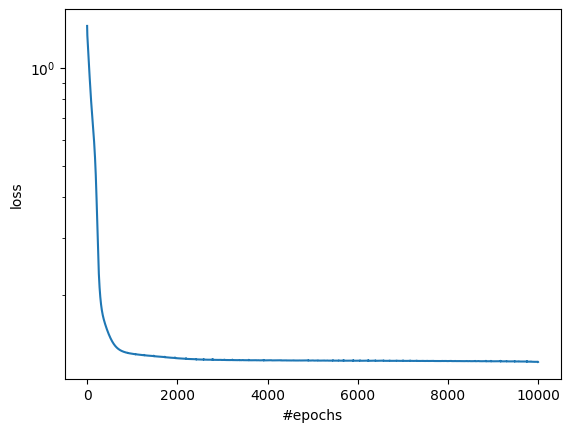

In [ ]:
# Plot the learning curve
plt.figure(2)
plt.clf()
plt.semilogy(range(len(hist)), np.array(hist))
plt.xlabel('#epochs')
plt.ylabel('loss')

The learned parameter is stored in `model.params`. Recall that the true value is $a=p[0:3] =(1,2,3)$ and $b =p[3:6]=(0,0,0)$

In [ ]:
model.params

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 3.641171  ,  3.5293756 ,  4.6063156 , -0.02696157, -0.97251844,
         0.9244065 ]], dtype=float32)>